<a href="https://colab.research.google.com/github/Rebecca-202211/dataanalytics/blob/main/ab_test_conversion_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [11]:
%matplotlib inline

In [12]:
sns.set(style = 'whitegrid')
font = {'family': 'Helvetica',
        'weight': 'bold',
        'size': 14}
mpl.rc('font', **font)

In [13]:
# raise conversion rate from 0.13 to 0.15
# to know the number of the data that is needed(per group: control/ experimental)
effect_size = sms.proportion_effectsize(0.13,0.15)
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)
required_n = ceil(required_n)

In [14]:
print(required_n)

4720


In [24]:
df = pd.read_csv('/content/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [26]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There is an overlab between the control group and the treatment group.
Extract the control group with old page and the treatment group with new page.

In [27]:
# detect overlab accounts
session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [31]:
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [34]:
# set the control group and the experimental group
control_sample = df[df['group'] == 'control'].sample(n = required_n,random_state = 22)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state = 22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)

In [36]:
ab_test.reset_index(drop = True, inplace = True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [37]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [39]:
# confirm the number of each groups
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [41]:
conversion_rates = ab_test.groupby('group')['converted']
std_p = lambda x: np.std(x)
se_p = lambda x: stats.sem(x)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


<ipython-input-45-24eec70a0e90>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci = False)


Text(0, 0.5, 'Converted (proportion)')

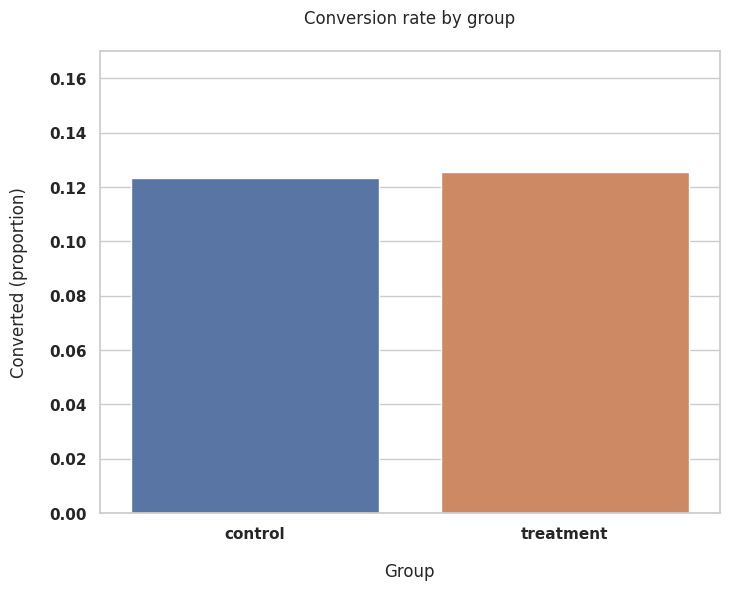

In [45]:
plt.figure(figsize = (8,6))
sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci = False)
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad = 20)
plt.xlabel('Group', labelpad = 15)
plt.ylabel('Converted (proportion)', labelpad = 15)

In [52]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]
z_stat, pval = proportions_ztest(successes, nobs= nobs)

In [53]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]
